# Parcialito PIB - Compresión de imágenes

Importo las librerías necesarias

In [1]:
import matplotlib.pyplot as plt
import pydicom
import numpy as np

Defino el path a la imagen DICOM y lo uso para leer la imagen.

In [2]:
path = './img.dcm'
img = pydicom.dcmread(path).pixel_array

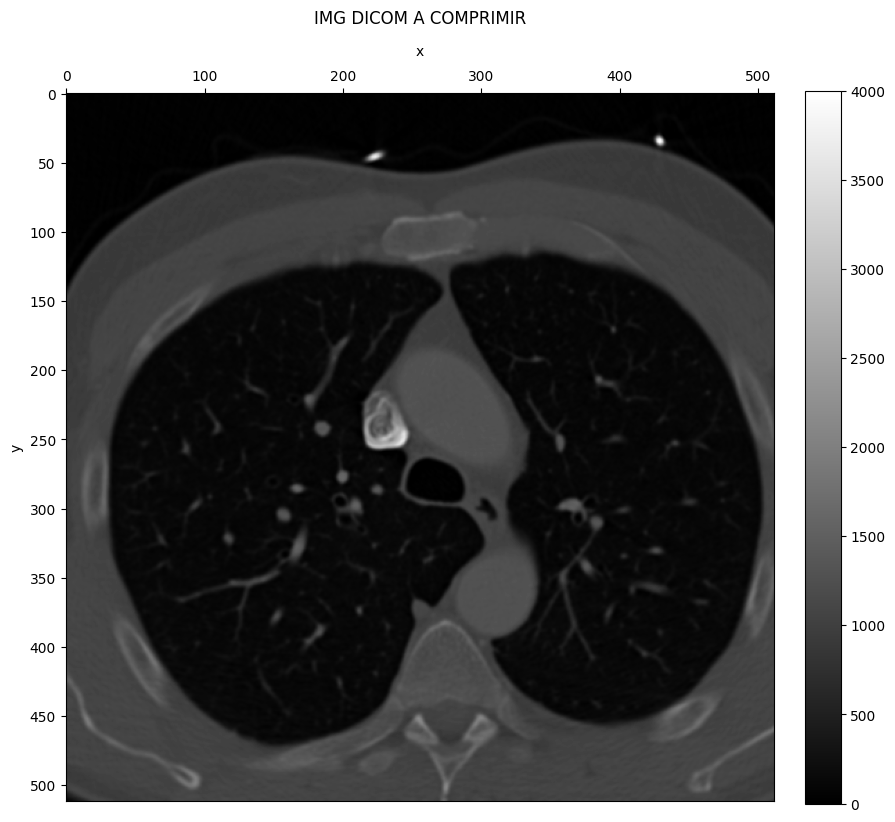

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img, cmap='gray')
plt.colorbar(ax.imshow(img, cmap='gray'), ax=ax, fraction=0.046, pad=0.04)

ax.set_title('IMG DICOM A COMPRIMIR', pad = 50)
ax.set_xlabel('x')
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 10
ax.xaxis.set_ticks_position('top')
ax.set_ylabel('y')
y = img.shape[0]
ax.set_yticks(np.arange(0, y, 50))

plt.show()

## Huffman coding

El algoritmo de Huffman es un algoritmo de compresión sin pérdida. La idea es asignar códigos de longitud variable a los símbolos de entrada, de manera que los símbolos más frecuentes tengan códigos más cortos. 

### Implementación

Voy a usar 3 funciones: `find_huffman_codes`, `huffman_encode` y `huffman_decode`.
La primera es una función auxiliar para la codificación que recorre un árbol desde un nodo hoja hasta la raíz y devuelve el código de Huffman para ese símbolo. Las otras dos son las funciones principales de codificación y decodificación.

In [4]:
def find_huffman_code(tree,val):
  '''
  Auxiliar function to find the huffman code of a value
  '''
  code, root_node = tree[val]
  if root_node!='root':
    code = find_huffman_code(tree,root_node) + code
  return code

In [5]:
from typing import Dict, List, Tuple

def huffman_encode(image: np.ndarray) -> Tuple[Dict[int, str], str, int, int, float, float]:
    '''
    Compresses an image using Huffman coding.

    Args:
    - image: a 2D numpy array representing the image to be compressed

    Returns:
    - codes: a dictionary that maps each grayscale tone to its Huffman code
    - compressed_img: a string of 0's and 1's representing the compressed image
    - rows: the number of rows in the original image
    - cols: the number of columns in the original image
    '''

    # Size of the image in pixels
    rows, cols = [image.shape[0], image.shape[1]]

    # If k is the maximum value in the image, then the range of values of the image is [0, k]
    k = np.max(image)

    # Normalized histogram
    normalized_hist = np.histogram(image, bins=k+1)[0] / (rows * cols)

    # Array of probabilities of each tone
    prob_tono = []
    
    # List of grayscale tones in the image
    tonos_list = []

    for tono in range(len(normalized_hist)):
        if normalized_hist[tono] != 0:
            prob_tono.append([normalized_hist[tono], tono])
            tonos_list.append(tono)
            
    # Sort the array of probabilities from smallest to largest
    prob_tono.sort(key=lambda x: x[0])

    # Dictionary that represents the Huffman tree
    tree = {}

    # Create the Huffman tree
    num_nodos = 0
    while len(prob_tono) > 1:
        a1 = prob_tono.pop(0)
        a2 = prob_tono.pop(0)
                
        suma_prob = a1[0] + a2[0]
        nodo = [suma_prob, f'N#{num_nodos}']
        tree[ a1[1] ] = ['0', nodo[1]]
        tree[ a2[1] ] = ['1', nodo[1]]

        num_nodos += 1  
        
        prob_tono.append(nodo)
        prob_tono.sort(key=lambda x: x[0])
    # Final node of the Huffman tree
    tree[f'N#{num_nodos-1}'] = ['', 'root']
    
    # Dictionary that maps each tone to its Huffman code
    codes = {}
    for tono in tonos_list:
        codes[tono] = find_huffman_code(tree,tono)
            
    # Generate a list of strings of 0's and 1's with the codes for each grayscale tone in the image
    compressed_img = []
    for r in range(rows):
        for c in range(cols):
            compressed_img.append(codes[image[r,c]])   
            
    return codes, compressed_img, rows, cols

codigos, img_c, rows, cols, = huffman_encode(img)

In [6]:
def huffman_decode(codes: dict, compressed_image: list, rows: int, cols: int) -> np.ndarray:
  '''
  Decodes a Huffman-encoded image.
  
  codes: dictionary of Huffman codes for each grayscale tone
  compressed_image: compressed image as a list of strings of Huffman codes
  rows: number of rows in the original image
  cols: number of columns in the original image
  '''
  
  # Invert the Huffman code dictionary so that the codes are the keys
  inv_codes = {v: k for k, v in codes.items()}
  
  # Decode the codes to obtain the grayscale tone values
  decoded_image = []
  for code in compressed_image:
      decoded_image.append(inv_codes[code])
          
  # Reshape the grayscale tone values into the original image shape
  original_image = np.reshape(decoded_image, (rows, cols))
  
  return original_image

# show the decoded image
img_d = huffman_decode(codigos, img_c, rows, cols)

## Comparación de resultados

Vemos si hay diferencia (a simple vista) entre la imagen original y la comprimida.

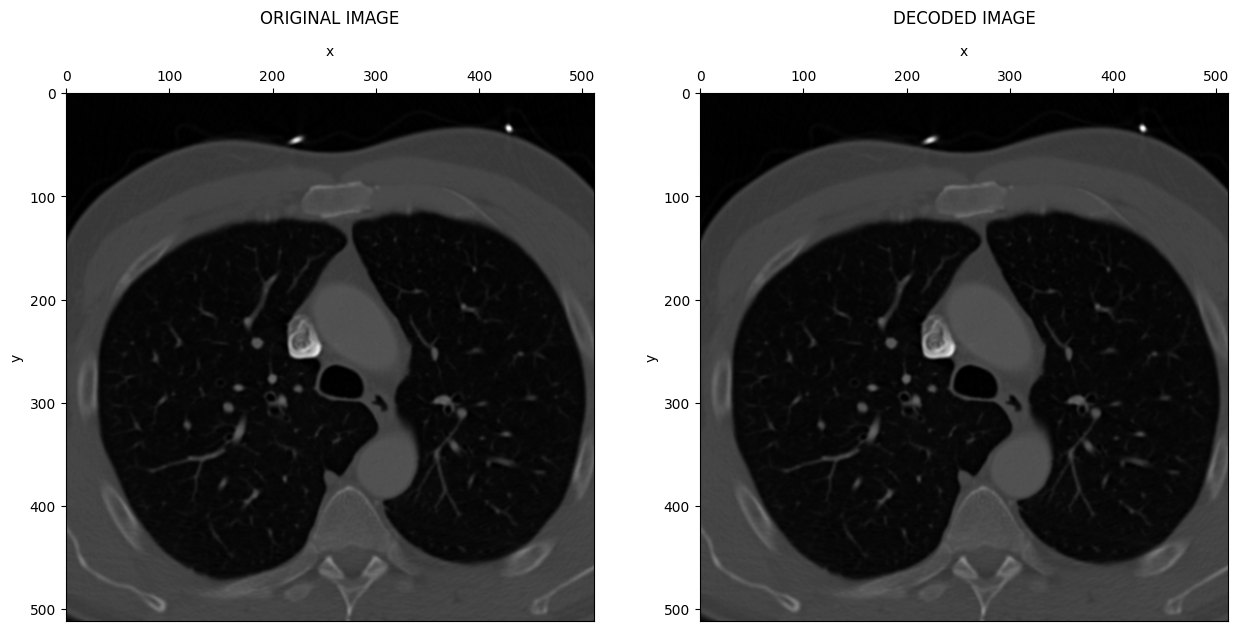

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('ORIGINAL IMAGE', pad = 50)
ax[0].set_xlabel('x')
ax[0].xaxis.set_label_position('top')
ax[0].xaxis.labelpad = 10
ax[0].xaxis.set_ticks_position('top')
ax[0].set_ylabel('y')

ax[1].imshow(img_d, cmap='gray')
ax[1].set_title('DECODED IMAGE', pad = 50)
ax[1].set_xlabel('x')
ax[1].xaxis.set_label_position('top')
ax[1].xaxis.labelpad = 10
ax[1].xaxis.set_ticks_position('top')
ax[1].set_ylabel('y')

plt.show()


A simple vista no se nota diferencia entre la imagen original y la comprimida. Vamos a ver si la computadora puede notar la diferencia.

In [8]:
print('Las imagenes son iguales?', np.array_equal(img, img_d))

Las imagenes son iguales? True


Vemos que se logró recuperar una copia exacta de la imagen original ya que la computadora no encontró diferencia entre ambas.